## Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [24]:
import SDA
import SDA.analytics
import SDA.clustquality
import SDA.stageprocess

import mne
import numpy
import pandas
import sklearn.preprocessing

pandas.set_option("display.precision", 2)

## Features

In [3]:
epochs = mne.read_epochs("m10/epochs_filt_rr-epo.fif")

Reading d:\HSE\year-3\HSE\CourseProject\m10\epochs_filt_rr-epo.fif ...
    Found the data of interest:
        t =    -500.00 ...     500.00 ms
        0 CTF compensation matrices available
Not setting metadata
1046 matching events found
No baseline correction applied
0 projection items activated


In [4]:
df_features = pandas.read_feather('m10/features.feather')
df_features.describe()

,0,1,2
count,1046.00,1046.00,1046.00
mean,8.89,5.13,2.81
std,0.02,0.71,1.31
min,8.83,1.38,-1.00
25%,8.88,4.70,2.05
50%,8.89,5.16,2.94
75%,8.90,5.61,3.73
max,8.93,6.95,5.62


In [5]:
features = sklearn.preprocessing.StandardScaler().fit_transform(df_features.to_numpy())
pandas.DataFrame(features, columns = df_features.columns).describe()

,0,1,2
count,1.05e+03,1.05e+03,1.05e+03
mean,-7.32e-14,8.15e-16,1.09e-16
std,1.00e+00,1.00e+00,1.00e+00
min,-3.26e+00,-5.27e+00,-2.92e+00
25%,-5.74e-01,-6.10e-01,-5.83e-01
50%,1.77e-01,4.67e-02,1.00e-01
75%,7.25e-01,6.69e-01,7.00e-01
max,2.24e+00,2.56e+00,2.15e+00


## SDA

In [6]:
result, df_st_edges = SDA.SDA().apply(features)

Applying to 1046 samples with 3 features each
Running stage 1


  0%|          | 0/589 [00:00<?, ?it/s]

Running stage 2


  0%|          | 0/672 [00:00<?, ?it/s]

In [22]:
result.to_csv('m10/result.csv')
df_st_edges.to_csv('m10/df_st_edges.csv')

## Analysis

### Find best row

In [7]:
results = SDA.analytics.best_results(result, key = 'Avg-Silh')
results

,St_len_min,K_nb_max,N_cl_max,N_stages,Cl_cen,St_edges,Ward_dist,Cen_dist,Silh,Cal-Har,Dav-Bold,Avg-Silh,Avg-Cal-Har,Avg-Dav-Bold
78,40,35,20,3,Median,"[0, 245, 670, 1046]",278.69,1.14,0.06,144.33,4.77,0.13,142.44,3.87
109,60,35,10,4,Mode,"[0, 94, 681, 864, 1046]",242.83,1.55,-0.01,100.52,3.38,0.15,105.42,1.83
117,60,40,10,5,Median,"[0, 94, 251, 665, 864, 1046]",156.35,1.25,-0.04,108.28,5.41,0.13,82.33,1.95
54,20,45,10,6,Median,"[0, 94, 251, 566, 681, 856, 1046]",128.53,1.20,-0.06,90.15,6.68,0.13,68.47,2.42
16,0,40,20,7,Mode,"[0, 94, 358, 566, 609, 864, 977, 1046]",113.11,1.34,-0.08,68.05,10.53,0.12,56.72,2.08
3,0,35,15,8,Median,"[0, 94, 250, 358, 486, 566, 681, 864, 1046]",85.41,1.11,-0.08,69.86,6.55,0.11,46.96,2.34
115,60,35,20,9,Mode,"[0, 94, 250, 358, 486, 560, 681, 864, 977, 1046]",85.07,1.15,-0.08,64.87,6.38,0.12,45.24,2.35
0,0,35,10,10,Median,"[0, 94, 250, 358, 490, 566, 609, 681, 789, 864...",55.10,1.08,-0.11,58.42,7.39,0.10,33.18,2.50
1,0,35,10,11,Mode,"[0, 94, 250, 358, 490, 566, 609, 681, 789, 864...",51.09,1.09,-0.11,53.50,7.65,0.11,30.57,2.59
18,0,45,10,12,Median,"[0, 46, 105, 250, 358, 490, 566, 609, 681, 795...",45.64,1.03,-0.14,51.28,7.08,0.10,26.27,2.50


In [8]:
best_result = SDA.analytics.best_result(result, key = 'Avg-Silh', n_stages = 10)
best_edges = numpy.array(best_result['St_edges'])
best_edges

array([   0,   94,  250,  358,  490,  566,  609,  681,  789,  864, 1046])

### Edge stats

In [9]:
SDA.analytics.edge_statistics(features, best_edges)

,Silh,Cal-Har,Dav-Bold,Ward,Centr
0,0.18,88.85,1.39,84.03,1.20
1,0.17,59.08,1.89,78.37,1.11
2,0.03,14.40,3.59,29.18,0.70
3,0.06,21.38,2.65,48.20,1.00
4,0.21,40.09,1.42,79.55,1.70
5,0.06,13.39,2.39,29.64,1.05
6,0.15,34.98,2.01,76.39,1.33
7,0.04,8.32,4.19,17.62,0.63
8,0.04,18.12,2.94,52.88,1.00


### Feature plots

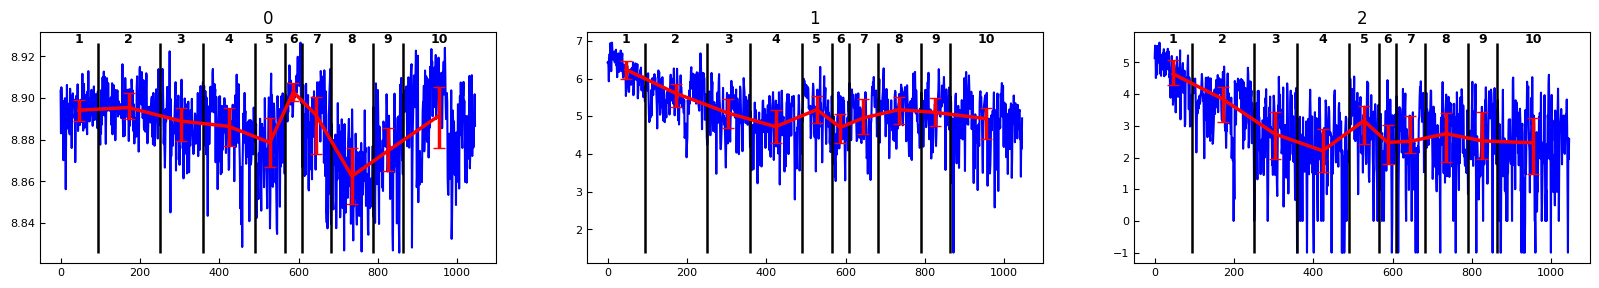

In [10]:
SDA.analytics.plot_features(df_features, best_edges)

### Lengths of stages

In [11]:
SDA.analytics.stage_timing(best_edges, epochs)

,0,1,2,3,4,5,6,7,8,9
"Start-end time, sec","(9.9, 90.7)","(92.3, 234.7)","(235.5, 334.7)","(335.5, 453.1)","(454.7, 517.9)","(518.7, 557.1)","(557.9, 619.5)","(620.3, 711.5)","(713.1, 777.9)","(778.7, 938.7)"
"Time length, sec",80.8,142.4,99.2,117.6,63.2,38.4,61.6,91.2,64.8,160.0
Number of epochs,94,156,108,132,76,43,72,108,75,182


### Overall stats

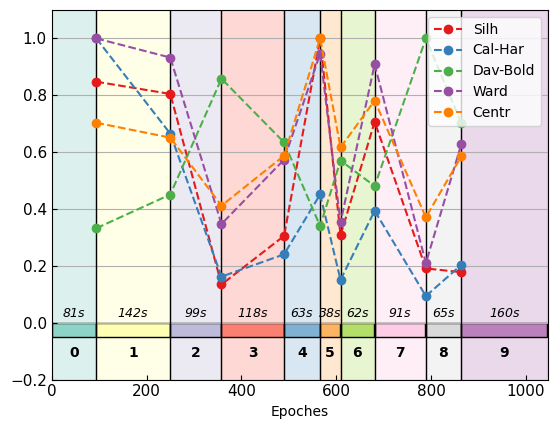

In [58]:
SDA.analytics.plot_stats(features, best_edges, epochs)